In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import RandomSampler
from sklearn.metrics import classification_report, accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import StratifiedShuffleSplit

import cv2
import time
import itertools
import os
import random

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Cleansed_and_removed/

#경로 확인
!pwd



Mounted at /content/drive
/content/drive/MyDrive/Cleansed_and_removed
/content/drive/MyDrive/Cleansed_and_removed


In [ ]:
def time_series():
    df_train = pd.read_csv('./df_train.csv')
    df_test= pd.read_csv('./df_test.csv')
    print(len(df_train), len(df_test))
    df_train = df_train[df_train['price']<1e+8]
    df_test = df_test[df_test['price']<1e+8]
    df_timeseries = pd.concat([df_test, df_train])

    df_timeseries = df_timeseries.sort_values(by='date', ascending = False)
    timeseries_idx = int(len(df_timeseries)*0.2)

    df_train = df_timeseries.iloc[timeseries_idx:]
    df_test = df_timeseries.iloc[:timeseries_idx]

    return df_train, df_test

18282 2584


<bound method NDFrame.describe of 2464      6000000
9045      2100000
9044       750000
8345      3500000
4614      6000000
           ...   
9039       500000
2066       800000
16799      400000
9553     25000000
5268       300000
Name: price, Length: 15959, dtype: int64>

## Define Feature_list

In [ ]:
all_features = ['year', 'area', 'online', 'base_charcoal', 'base_paper', 'base_fiber', 'base_canvas', 'base_hardboard', 'base_hanji', 'base_ceramic', 'base_terracotta', 'base_masonite', 'base_wood', 'base_leaf', 
            'base_silverpaper', 'base_metal', 'mate_gouache', 'mate_maca', 'mate_magic', 'mate_signpen', 'mate_colorpencil', 'mate_korean_ink', 'mate_korean_ink_and_color', 'mate_watercolor', 'mate_pencil', 
            'mate_oil_and_color', 'mate_ink', 'mate_color', 'mate_pen', 'mate_mixture', 'mate_pigment', 'mate_graphite', 'mate_acrylic', 'mate_conte', 'mate_collage', 'mate_engrave', 'mate_crayon', 'mate_enamel', 
            'mate_oilpastel', 'award', 'exhbn_solo', 'exhbn_group', 'era', 'is_death', 'predict_price', 'previous_sell_count', 'elapsed', 'height', 'width', 'author_age', 'GDP', 'CDS', 'Housing', 'KOSPI_100', 
            'MSCI Emerging', 'MSCI World', '1y_Bond_yield', 'S&P 500 VIX', 'Gold', 'OBFR', 'CSI', 'Inflation', 'pre_month_value', 'pre_month_count', 'pre_month_author_value', 'pre_month_author_count', 'pre_quarter_value', 
            'pre_quarter_count', 'pre_qt_author_value', 'pre_qt_author_count', 'pre_half_value', 'pre_half_count', 'pre_half_author_value', 'pre_half_author_count', 'pre_year_value', 'pre_year_count', 'pre_year_author_value', 
            'pre_year_author_count', 'news', 'KOSPI_100_growth', 'KOSPI_100_30_avg', 'MSCI_emerging_growth', 'MSCI_emerging_avg', 'MSCI_world_growth', 'MSCI_world_avg', 'One_year_bond_growth', 'One_year_bond_avg', 'VIX_growth', 
            'VIX_avg', 'Gold_growth', 'Gold_avg', 'KOSPI_100_MA20', 'KOSPI_100_90_growth', 'KOSPI_100_MA90', 'KOSPI_100_180_growth', 'KOSPI_100_MA180', 'KOSPI_100_365_growth', 'KOSPI_100_MA365', 'MSCI_emerging_MA20', 'MSCI_emerging_90_growth', 
            'MSCI_emerging_MA90', 'MSCI_emerging_180_growth', 'MSCI_emerging_MA180', 'MSCI_emerging_365_growth', 'MSCI_emerging_MA365', 'MSCI_world_MA20', 'MSCI_world_90_growth', 'MSCI_world_MA90', 'MSCI_world_180_growth', 'MSCI_world_MA180', 
            'MSCI_world_365_growth', 'MSCI_world_MA365', 'One_year_bond_MA20', 'One_year_bond_90_growth', 'One_year_bond_MA90', 'One_year_bond_180_growth', 'One_year_bond_MA180', 'One_year_bond_365_growth', 'One_year_bond_MA365', 'VIX_MA20', 
            'VIX_90_growth', 'VIX_MA90', 'VIX_180_growth', 'VIX_MA180', 'VIX_365_growth', 'VIX_MA365', 'Gold_MA20', 'Gold_90_growth', 'Gold_MA90', 'Gold_180_growth', 'Gold_MA180', 'Gold_365_growth', 'Gold_MA365', 'KOSPI_100_momentum', 'KOSPI_100_RSI', 
            'KOSPI_100_MACD', 'MSCI_emerging_momentum', 'MSCI_emerging_RSI', 'MSCI_emerging_MACD', 'MSCI_world_momentum', 'MSCI_world_RSI', 'MSCI_world_MACD', 'One_year_bond_momentum', 'One_year_bond_RSI', 'One_year_bond_MACD', 'Gold_momentum', 
            'Gold_RSI', 'Gold_MACD', 'VIX_momentum', 'VIX_RSI', 'VIX_MACD', 'trend_art_auction', 'trend_art_auction_company', 'trend_art_rental', 'trend_change_value', 'trend_change_count', 'trend_ratio_value', 'trend_ratio_count', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 
            'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',  'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_9', 'source_0', 'source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7',]

img_features = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']

art_feature = ['year', 'area', 'online', 'base_charcoal', 'base_paper', 'base_fiber', 'base_canvas', 'base_hardboard', 'base_hanji', 'base_ceramic', 'base_terracotta', 'base_masonite', 'base_wood', 'base_leaf', 
            'base_silverpaper', 'base_metal', 'mate_gouache', 'mate_maca', 'mate_magic', 'mate_signpen', 'mate_colorpencil', 'mate_korean_ink', 'mate_korean_ink_and_color', 'mate_watercolor', 'mate_pencil',
            'mate_oil_and_color', 'mate_ink', 'mate_color', 'mate_pen', 'mate_mixture', 'mate_pigment', 'mate_graphite', 'mate_acrylic', 'mate_conte', 'mate_collage', 'mate_engrave', 'mate_crayon', 'mate_enamel', 
            'mate_oilpastel', 'award', 'exhbn_solo', 'exhbn_group', 'era', 'is_death',  'elapsed', 'height', 'width', 'author_age',    'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_9', 'source_0', 'source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7',]

economic_feature = ['GDP', 'CDS', 'Housing', 'KOSPI_100', 'MSCI Emerging', 'MSCI World', '1y_Bond_yield', 'S&P 500 VIX', 'Gold', 'OBFR', 'CSI', 'Inflation',
                    'KOSPI_100_growth', 'KOSPI_100_30_avg', 'MSCI_emerging_growth', 'MSCI_emerging_avg', 'MSCI_world_growth', 'MSCI_world_avg', 'One_year_bond_growth', 'One_year_bond_avg', 'VIX_growth', 
            'VIX_avg', 'Gold_growth', 'Gold_avg', 'KOSPI_100_MA20', 'KOSPI_100_90_growth', 'KOSPI_100_MA90', 'KOSPI_100_180_growth', 'KOSPI_100_MA180', 'KOSPI_100_365_growth', 'KOSPI_100_MA365', 'MSCI_emerging_MA20', 'MSCI_emerging_90_growth', 
            'MSCI_emerging_MA90', 'MSCI_emerging_180_growth', 'MSCI_emerging_MA180', 'MSCI_emerging_365_growth', 'MSCI_emerging_MA365', 'MSCI_world_MA20', 'MSCI_world_90_growth', 'MSCI_world_MA90', 'MSCI_world_180_growth', 'MSCI_world_MA180', 
            'MSCI_world_365_growth', 'MSCI_world_MA365', 'One_year_bond_MA20', 'One_year_bond_90_growth', 'One_year_bond_MA90', 'One_year_bond_180_growth', 'One_year_bond_MA180', 'One_year_bond_365_growth', 'One_year_bond_MA365', 'VIX_MA20', 
            'VIX_90_growth', 'VIX_MA90', 'VIX_180_growth', 'VIX_MA180', 'VIX_365_growth', 'VIX_MA365', 'Gold_MA20', 'Gold_90_growth', 'Gold_MA90', 'Gold_180_growth', 'Gold_MA180', 'Gold_365_growth', 'Gold_MA365', 'KOSPI_100_momentum', 'KOSPI_100_RSI', 
            'KOSPI_100_MACD', 'MSCI_emerging_momentum', 'MSCI_emerging_RSI', 'MSCI_emerging_MACD', 'MSCI_world_momentum', 'MSCI_world_RSI', 'MSCI_world_MACD', 'One_year_bond_momentum', 'One_year_bond_RSI', 'One_year_bond_MACD', 'Gold_momentum', 
            'Gold_RSI', 'Gold_MACD', 'VIX_momentum', 'VIX_RSI', 'VIX_MACD'
]

trend_feature = ['predict_price', 'previous_sell_count','pre_month_value', 'pre_month_count', 'pre_month_author_value', 'pre_month_author_count', 'pre_quarter_value', 
            'pre_quarter_count', 'pre_qt_author_value', 'pre_qt_author_count', 'pre_half_value', 'pre_half_count', 'pre_half_author_value', 'pre_half_author_count', 'pre_year_value', 'pre_year_count', 'pre_year_author_value', 
            'pre_year_author_count', 'news',  'trend_art_auction', 'trend_art_auction_company', 'trend_art_rental', 'trend_change_value', 'trend_change_count', 'trend_ratio_value', 'trend_ratio_count'
]


feature_list=[art_feature, art_feature+economic_feature, art_feature+trend_feature, art_feature+img_features, art_feature+economic_feature+trend_feature, img_features, all_features]

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, RFE

##### 시계열 데이터의 경우 #######
df_train, df_test = time_series()

#### 층화추출의 경우 ##### 
# df_train = df_train_strt.copy()
# df_test = df_test_strt.copy()

x_art = df_train[art_feature]
x_economics = df_train[economic_feature]
x_trend = df_train[trend_feature]

y = np.log10(df_train['price']+1)

def feature_selections(df):
    selector = SelectKBest(f_regression, k=20)
    selector.fit(df, y)
    cols = selector.get_support(indices=True)
    features_df_new = df.iloc[:, cols]
    new_cols = features_df_new.columns
    return list(new_cols)

art_cols = feature_selections(x_art)
eco_cols = feature_selections(x_economics)
trend_cols = feature_selections(x_trend)

feature_list = [art_cols, art_cols+eco_cols, art_cols+trend_cols, art_cols+eco_cols+trend_cols, art_cols+eco_cols+trend_cols+img_features]
print(art_cols)
print(eco_cols)
print(trend_cols)

18282 2584
['year', 'area', 'online', 'base_paper', 'base_canvas', 'mate_korean_ink', 'mate_oil_and_color', 'mate_mixture', 'mate_acrylic', 'exhbn_solo', 'exhbn_group', 'era', 'elapsed', 'height', 'width', 'genre_0', 'genre_1', 'source_1', 'source_3', 'source_5']
['Housing', '1y_Bond_yield', 'Gold', 'Inflation', 'Gold_avg', 'One_year_bond_MA90', 'VIX_MA20', 'VIX_MA90', 'VIX_MA180', 'VIX_MA365', 'Gold_MA20', 'Gold_MA90', 'Gold_MA180', 'Gold_MA365', 'KOSPI_100_RSI', 'MSCI_emerging_RSI', 'MSCI_world_RSI', 'One_year_bond_RSI', 'Gold_RSI', 'VIX_RSI']
['predict_price', 'previous_sell_count', 'pre_month_author_value', 'pre_month_author_count', 'pre_quarter_value', 'pre_quarter_count', 'pre_qt_author_value', 'pre_qt_author_count', 'pre_half_count', 'pre_half_author_value', 'pre_half_author_count', 'pre_year_value', 'pre_year_author_value', 'pre_year_author_count', 'trend_art_auction', 'trend_art_auction_company', 'trend_art_rental', 'trend_change_value', 'trend_change_count', 'trend_ratio_coun

In [ ]:
df_train = pd.read_csv('./df_train.csv')
df_test= pd.read_csv('./df_test.csv')
df_train = df_train[df_train['price']<1e+8]
df_test = df_test[df_test['price']<1e+8]

df = pd.concat([df_train, df_test], ignore_index=True).reset_index()

df_2016 = df[df['date'].between('2016-01-01','2017-01-01')]
df_2017 = df[df['date'].between('2017-01-01','2018-01-01')]
df_2018 = df[df['date'].between('2018-01-01','2019-01-01')]
df_2019 = df[df['date'].between('2019-01-01','2020-01-01')]
df_2020 = df[df['date'].between('2020-01-01','2021-01-01')]
df_2021 = df[df['date'].between('2021-01-01','2022-01-01')]
print(len(df_2016), len(df_2017), len(df_2018), len(df_2019), len(df_2020), len(df_2021))

df_2016_count = dict(df_2016['author'].value_counts())
df_2017_count = dict(df_2017['author'].value_counts())
df_2018_count = dict(df_2018['author'].value_counts())
df_2019_count = dict(df_2019['author'].value_counts())
df_2020_count = dict(df_2020['author'].value_counts())
df_2021_count = dict(df_2021['author'].value_counts())

dict_count = {'2016':df_2016_count, '2017':df_2017_count, '2018':df_2018_count, '2019':df_2019_count, '2020':df_2020_count, '2021':df_2021_count}

# df_2016 = pd.DataFrame.from_dict(df_2016_count)
# df_2016.fillna(0, inplace=True)

# df_2017 = pd.DataFrame.from_dict(df_2017_count)
# df_2017.fillna(0, inplace=True)

# df_2018 = pd.DataFrame.from_dict(df_2018_count)
# df_2018.fillna(0, inplace=True)

# df_2019 = pd.DataFrame.from_dict(df_2019_count)
# df_2019.fillna(0, inplace=True)

# df_2020 = pd.DataFrame.from_dict(df_2020_count)
# df_2020.fillna(0, inplace=True)

# df_2021 = pd.DataFrame.from_dict(df_2021_count)
# df_2021.fillna(0, inplace=True)

df_total_count = pd.DataFrame.from_dict(dict_count)
df_total_count.fillna(0, inplace=True)

# df_total_count.to_csv('./author_count.csv')

3000 3667 3543 3559 3755 2424


In [ ]:
# TODO
# 층화추출 전략 세우기(0개일 때, 1개일 때, 2개 이상일 때)
# feature_list 변수 추가해서 실험 진행할 때마다 log 남길 수 있게 코드 수정하기
# 실험 진행
splitter=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

df_train_strt = pd.DataFrame()
df_test_strt = pd.DataFrame()
year_df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021]
for df in year_df_list:

    for idx in df_total_count.index:
        if len(df[df['author']==idx])<2:
            df = df.drop(df[df['author']==idx].index)
    X = df
    y = df['author']

    for train_idx, test_idx in splitter.split(df, df['author']):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]
    if len(df_train_strt)<1:
        df_train_strt = train
        df_test_strt = test
    else:
        df_train_strt = pd.concat([df_train_strt, train])
        df_test_strt = pd.concat([df_test_strt, test])

print(len(df_train_strt))
print(len(df_test_strt))

15929
3987


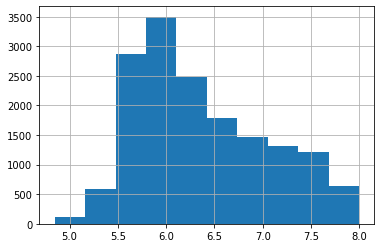

In [ ]:
np.log10(df_train['price']).hist()

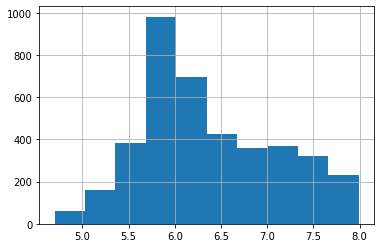

In [ ]:
np.log10(df_test['price']).hist()

In [ ]:
import datetime as dt
x = dt.datetime.now()
today = f'{x.year}{x.month}{x.day}-{x.hour}{x.minute}{x.second}'
today

'20221212-10543'

Early Stopping : 36


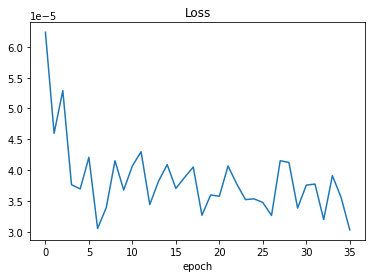

####0##### : 261.4589383914327, 260.3359751756852, 7.929159030561199
####1##### : 223.3911672863547, 180.48320812577833, 0.8343080978502798
####2##### : 3714.050430589785, 3005.6864294791667, 0.8616884130224912
                     Data    epoch learning rate batch size dropout  \
1                 ALL_sel  36/1000          0.01        128     0.2   
2  ALL_sel_regression_PC1  36/1000          0.01        128     0.2   
3  ALL_sel_regression_PC2  36/1000          0.01        128     0.2   
4  ALL_sel_regression_PC3  36/1000          0.01        128     0.2   

          RMSE          MAE      MAPE  
1     1831.894     886.9032  3.349407  
2   261.458938   260.335975  7.929159  
3   223.391167   180.483208  0.834308  
4  3714.050431  3005.686429  0.861688  
---------------------------------------------------------
Early Stopping : 87


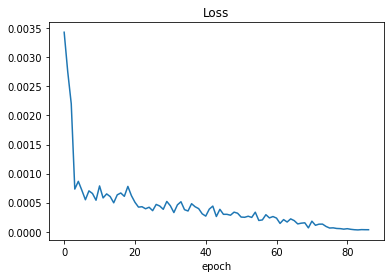

####0##### : 145.4068330630061, 143.47454073033708, 4.577020416041784
####1##### : 248.9241066754196, 164.5267696139477, 0.4806159280281844
####2##### : 3811.045153055007, 3124.3111803962465, 0.9135739242751438
                                Data    epoch learning rate batch size  \
1                            ALL_sel  36/1000          0.01        128   
2             ALL_sel_regression_PC1  36/1000          0.01        128   
3             ALL_sel_regression_PC2  36/1000          0.01        128   
4             ALL_sel_regression_PC3  36/1000          0.01        128   
5                 Art+Ecnonomics_sel  87/1000          0.01        128   
6  Art+Ecnonomics_sel_regression_PC1  87/1000          0.01        128   
7  Art+Ecnonomics_sel_regression_PC2  87/1000          0.01        128   
8  Art+Ecnonomics_sel_regression_PC3  87/1000          0.01        128   

  dropout         RMSE          MAE      MAPE  
1     0.2     1831.894     886.9032  3.349407  
2     0.2   261.458938   2

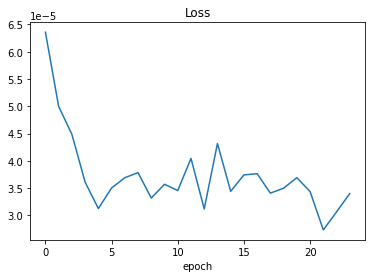

####0##### : 19344414.753725007, 567036.3064357695, 8719.120006483068
####1##### : 241624.02600138646, 10745.912018107478, 57.162986218860894
####2##### : 681704.0975806743, 44560.34927010926, 11.761019372024702
                                 Data    epoch learning rate batch size  \
1                             ALL_sel  36/1000          0.01        128   
2              ALL_sel_regression_PC1  36/1000          0.01        128   
3              ALL_sel_regression_PC2  36/1000          0.01        128   
4              ALL_sel_regression_PC3  36/1000          0.01        128   
5                  Art+Ecnonomics_sel  87/1000          0.01        128   
6   Art+Ecnonomics_sel_regression_PC1  87/1000          0.01        128   
7   Art+Ecnonomics_sel_regression_PC2  87/1000          0.01        128   
8   Art+Ecnonomics_sel_regression_PC3  87/1000          0.01        128   
9                       Art+Trend_sel  24/1000          0.01        128   
10       Art+Trend_sel_regression_PC1 

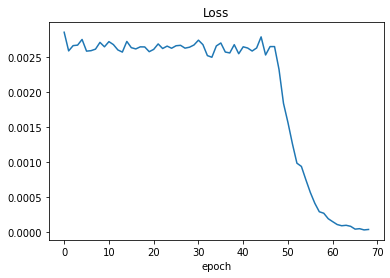

####0##### : 102.82732803819553, 100.07751679824563, 3.3310442904473576
####1##### : 271.0170968092476, 173.7841507398754, 0.4233945427841347
####2##### : 3846.694372869088, 3167.6983428962462, 0.9328607446540703
                                      Data    epoch learning rate batch size  \
1                                  ALL_sel  36/1000          0.01        128   
2                   ALL_sel_regression_PC1  36/1000          0.01        128   
3                   ALL_sel_regression_PC2  36/1000          0.01        128   
4                   ALL_sel_regression_PC3  36/1000          0.01        128   
5                       Art+Ecnonomics_sel  87/1000          0.01        128   
6        Art+Ecnonomics_sel_regression_PC1  87/1000          0.01        128   
7        Art+Ecnonomics_sel_regression_PC2  87/1000          0.01        128   
8        Art+Ecnonomics_sel_regression_PC3  87/1000          0.01        128   
9                            Art+Trend_sel  24/1000          0.01  

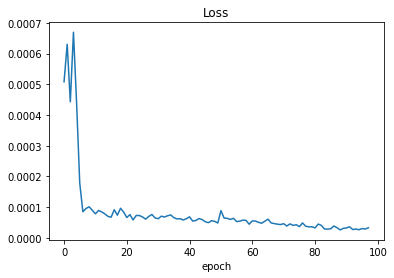

####0##### : 181.03078778011377, 179.48157250527055, 5.6107042576913875
####1##### : 235.6637910137733, 165.11952020547946, 0.5703370583161004
####2##### : 3779.6211463330596, 3086.297775, 0.8975312435524133
                                      Data    epoch learning rate batch size  \
1                                  ALL_sel  36/1000          0.01        128   
2                   ALL_sel_regression_PC1  36/1000          0.01        128   
3                   ALL_sel_regression_PC2  36/1000          0.01        128   
4                   ALL_sel_regression_PC3  36/1000          0.01        128   
5                       Art+Ecnonomics_sel  87/1000          0.01        128   
6        Art+Ecnonomics_sel_regression_PC1  87/1000          0.01        128   
7        Art+Ecnonomics_sel_regression_PC2  87/1000          0.01        128   
8        Art+Ecnonomics_sel_regression_PC3  87/1000          0.01        128   
9                            Art+Trend_sel  24/1000          0.01       

In [ ]:
result_pd = pd.DataFrame(columns=['Data', 'epoch', 'learning rate', 'batch size', 'dropout', 'RMSE', 'MAE', 'MAPE'])
idx=1
flag=True
random_seed = 42
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
min_val_loss = np.Inf

import datetime as dt
x = dt.datetime.now()
today = f'{x.month}{x.day}-{x.hour}{x.minute}'
today

epoch_counter_list = [1000]
lr_list = [0.01]
batch_list  = [128]
droppout_list = [0.2]

for epoch_counter in epoch_counter_list:
    counter = 0
    for lr in lr_list:
        counter = 0
        for batch in batch_list:
            counter = 0
            for dropout in droppout_list:
                counter = 0
                if flag==False:
                    feature_list=[all_features]
                    flag=True
                else:
                    feature_list=[art_feature, art_feature+economic_feature, art_feature+trend_feature, art_feature+img_features, art_feature+economic_feature+trend_feature, img_features, all_features]
                    # feature_list = [art_cols, art_cols+eco_cols, art_cols+trend_cols, art_cols+eco_cols+trend_cols, art_cols+eco_cols+trend_cols+img_features]

                for features in feature_list:

                    df_train, df_test = time_series()
                    df_test = df_test[df_test['price']<1e+8]

                    df_train = df_train.reset_index()
                    df_test = df_test.reset_index()

                    train_feature = df_train[features].to_numpy()
                    train_target = np.log10(df_train['price']+1).to_numpy()

                    test_feature = df_test[features].to_numpy()
                    test_target = np.log10(df_test['price']+1).to_numpy()



                    class TensorData(Dataset):

                        def __init__(self, x_data, y_data):
                            self.x_data = torch.FloatTensor(x_data)
                            self.y_data = torch.FloatTensor(y_data)
                            self.len = self.y_data.shape[0]

                        def __getitem__(self, index):

                            return self.x_data[index], self.y_data[index] 

                        def __len__(self):
                            return self.len

                    trainsets = TensorData(train_feature, train_target)
                    testsets = TensorData(test_feature, test_target)

                    trainloader = torch.utils.data.DataLoader(trainsets, batch_size=batch, shuffle=True)
                    testloader = torch.utils.data.DataLoader(testsets, batch_size=batch, shuffle=True)

                    class Regressor(nn.Module):
                        def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
                            super().__init__() # 모델 연산 정의
                            self.fc1 = nn.Linear(input_dim, hidden_dim1, bias=True) 
                            self.fc2 = nn.Linear(hidden_dim1, hidden_dim2, bias=True)
                            self.fc3 = nn.Linear(hidden_dim2, hidden_dim3, bias=True)
                            self.fc4 = nn.Linear(hidden_dim3, output_dim, bias=True)
                            self.dropout = nn.Dropout(dropout) 

                        def forward(self, x): 
                            x = F.relu(self.fc1(x))
                            x = self.dropout(F.relu(self.fc2(x)))
                            x = self.dropout(F.relu(self.fc3(x)))
                            x = F.leaky_relu(self.fc4(x))

                            return x
                    input_dim = len(features)
                    hidden_dim1 = 1600
                    hidden_dim2 = 800
                    hidden_dim3 = 400
                    output_dim = 1

                    model = Regressor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
                    criterion = nn.MSELoss()

                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)

                    loss_ = [] # loss를 저장할 리스트.
                    n = len(trainloader)
                    n_epochs_stop = 6
                    epochs_no_improve=0
                    early_stop = False
                    for epoch in range(epoch_counter):
                        running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

                        for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
                            
                            inputs, values = data # data에는 X, Y가 들어있다.

                            optimizer.zero_grad() # 최적화 초기화.

                            outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
                            loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
                            loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
                            optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

                            running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
                            running_loss = running_loss/len(trainloader)
                            if running_loss < min_val_loss:
                                # torch.save(model)
                                epochs_no_improve = 0
                                min_val_loss = running_loss
                            else:
                                epochs_no_improve += 1

                            if epoch>=20 and epochs_no_improve==n_epochs_stop:
                                print(f'Early Stopping : {epoch}')
                                early_stop=True
                                break
                        if early_stop:
                            break
                        loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

                    plt.plot(loss_)
                    plt.title('Loss')
                    plt.xlabel('epoch')
                    plt.show()

                    def evaluation(dataloader):

                        predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
                        actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

                        with torch.no_grad():
                            model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

                            for data in dataloader:
                                inputs, values = data
                                outputs = model(inputs)

                                predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
                                actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

                        predictions = predictions.numpy() # 넘파이 배열로 변경.
                        actual = actual.numpy() # 넘파이 배열로 변경.
                        rmse = np.sqrt(mean_squared_error(y_true=10**actual, y_pred=10**predictions))*(10**-4) # sklearn을 이용해 RMSE를 계산.
                        mae = mean_absolute_error(y_true=10**actual, y_pred=10**predictions)*(10**-4)
                        mape = mean_absolute_percentage_error(y_true=10**actual, y_pred=10**predictions)

                        return rmse, mae, mape, predictions, actual

                    train_rmse,train_mae,train_mape, train_predictions, train_actual = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
                    test_rmse,test_mae,test_mape, test_predictions, test_actual = evaluation(testloader)

                    predict_df = df_test
                    predict_df['predict'] = 10**test_predictions

                    price_threshold_1 = 1e+6
                    price_threshold_2 = 1e+7
                    price_threshold_3 = 1e+8

                    predict_df['label'] = 0

                    for i in range(len(predict_df)):
                        if predict_df['price'][i]<price_threshold_1:
                            predict_df['label'][i] = 0
                        elif predict_df['price'][i]>=price_threshold_1 and predict_df['price'][i]<price_threshold_2:
                            predict_df['label'][i] = 1
                        # elif predict_df['price'][i]>=price_threshold_2 and predict_df['price'][i]<price_threshold_3:
                        #     predict_df['label'][i] = 2
                        else:
                            predict_df['label'][i] = 2

                    # feature_list=[art_feature, art_feature+economic_feature, art_feature+trend_feature, art_feature+img_features, 
                    # art_feature+economic_feature+trend_feature, img_features, all_features]
                    if features == art_feature:
                        data = 'Art'
                    elif features == art_feature+economic_feature:
                        data = 'Art+Economics'
                    elif features == art_feature+trend_feature:
                        data = 'Art+Trend'
                    elif features == art_feature+img_features:
                        data = 'Art+Image'
                    elif features == art_feature+economic_feature+trend_feature:
                        data = 'Art+Economics+Trend'
                    elif features == img_features:
                        data = 'Image'
                    elif features == art_feature+economic_feature+trend_feature+img_features:
                        data = 'ALL'
                    else:
                        if features == art_cols:
                            data = 'ALL_sel'
                        elif features == art_cols+eco_cols:
                            data = 'Art+Ecnonomics_sel'
                        elif features == art_cols+trend_cols:
                            data = 'Art+Trend_sel'
                        elif features == art_cols+eco_cols+trend_cols:
                            data = 'Art+Economics+Trend_sel'
                        elif features == art_cols+eco_cols+trend_cols+img_features:
                            data = 'ALL_sel'
                        else:
                            data = 'ALL_unknown'

                    
                    filename = f'result_{lr}_{batch}_{random_seed}_{today}.csv'
                    # if len(feature_list)>6:
                    #     filename = f'result_{today}.csv'
                    #     if counter == 0:
                    #         data = 'Art'
                    #     elif counter == 1:
                    #         data = 'Art+Economics'
                    #     elif counter == 2:
                    #         data = 'Art+Trend'
                    #     elif counter == 3:
                    #         data = 'Art+Image'
                    #     elif counter == 4:
                    #         data = 'Art+Economics+Trend'
                    #     elif counter == 5:
                    #         data = 'Image'
                    #     else:
                    #         data =' ALL'
                    # elif len(feature_list)==6:
                    #     filename = f'result_{today}.csv'
                    #     if counter == 0:
                    #         data = 'Art+Economics'
                    #     elif counter == 1:
                    #         data = 'Art+Trend'
                    #     elif counter == 2:
                    #         data = 'Art+Image'
                    #     elif counter == 3:
                    #         data = 'Art+Economics+Trend'
                    #     elif counter == 4:
                    #         data = 'Image'
                    #     else:
                    #         data =' ALL'
                    # else:
                    #     filename = f'result_partial_{today}.csv'
                    #     if counter == 0:
                    #         data = 'Art'
                    #     elif counter == 1:
                    #         data = 'Art+Economics'
                    #     elif counter == 2:
                    #         data = 'Art+Trend'
                    #     else:
                    #         data = 'Tabular'

                        # ['Data', 'epoch', 'learning rate', 'batch size', 'dropout', 'RMSE', 'MAE', 'MAPE']
                    result_pd.loc[idx, :] = [data, f'{epoch}/{epoch_counter}', lr, batch, dropout, test_rmse, test_mae, test_mape]
                    idx+=1
                    counter+=1
                    for i in range(3):
                        sub_df = predict_df[predict_df['label']==i]
                        rmse = np.sqrt(mean_squared_error(sub_df['price'], sub_df['predict']))*(10**-4)
                        mae = mean_absolute_error(sub_df['price'], sub_df['predict'])*(10**-4)
                        mape = mean_absolute_percentage_error(sub_df['price'], sub_df['predict'])
                        print(f'####{i}##### : {rmse}, {mae}, {mape}')
                        result_pd.loc[idx, :] = [f'{data}_regression_PC{i+1}', f'{epoch}/{epoch_counter}', lr, batch, dropout, rmse, mae, mape]
                        idx+=1
                    print(result_pd)
                    print('---------------------------------------------------------')
                    result_pd.to_csv(f'.{filename}')